In [58]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

import jax
device = jax.default_backend()
print(device)

gpu


In [19]:
df = pd.read_csv('../data/player_stats_trends.csv')
tournament_stats = pd.read_csv('../data/tournament_stats.csv')
goals = pd.read_csv('../data/goals.csv')
awards = pd.read_csv('../data/awards.csv')

In [20]:
awards['Year'] = awards['Season'].apply(lambda x: float(str(x)[-2:]))
awards = awards.drop(columns=['Season', 'Club/Country'])
awards = awards.groupby('Award').filter(lambda x: len(x) >= 5)
awards = awards[~awards['Award'].isin(["Winner Ballon d'Or", 'Footballer of the Year', 'UEFA Best Player in Europe', "The Best FIFA Men's Player", 'Player of the Year', 'Top goal scorer', 'African Footballer of the Year', 'TM-Player of the season'])]


awards = pd.get_dummies(awards, columns=['Award'], prefix='', prefix_sep='')

for col in awards.columns:
    if col not in ['Player', 'Year']:
        awards[col] = awards[col].astype(int)
awards = awards.groupby(['Player', 'Year']).sum().reset_index()


In [21]:
def goal_fixer(goals):
    try:
        return int(goals)
    except:
        return 0
def run_model(X, y):
    glm = sm.GLM(endog=y, exog= X, family=sm.families.Gaussian())
    X = sm.add_constant(X)
    glm_results = glm.fit()
    return glm_results
def remove_p(X, glm_results, p):
    to_remove = []
    for i in glm_results.pvalues.index:
        if glm_results.pvalues[i] > p:
            to_remove.append(i)
        elif np.isnan(glm_results.pvalues[i]):
            to_remove.append(i)
    X = X.drop(columns=to_remove)
    return X

In [22]:
tournament_stats['Year'] = tournament_stats['Season'].apply(lambda x: float(x[-2:]))
tournament_stats = tournament_stats.drop('Season', axis=1)
tournament_stats = tournament_stats.query('Year >= 8 & Year <= 23')
tournament_stats['Goals'] = tournament_stats['Goals'].apply(lambda x: goal_fixer(x))
tournament_stats['Minutes played'] = tournament_stats['Minutes played'].apply(lambda x: goal_fixer(x))

comp_goals = tournament_stats.pivot_table(index=['Year', 'Player'], columns='Competition', aggfunc='sum')['Goals'].replace(np.nan, 0).reset_index()
comp_goals = comp_goals.rename(columns=lambda x: x + '_Goals')
comp_goals.rename(columns={'Year_Goals': 'Year', 'Player_Goals' : 'Player'}, inplace=True)

Goals = []
for i in comp_goals.iterrows():
    rs = 0
    for j in i[1].index:
        if j not in ['Player', 'Year']:
            rs += i[1][j]
    Goals.append(rs)
comp_goals['Goals'] = Goals

comp_mins = tournament_stats.pivot_table(index=['Year', 'Player'], columns='Competition', aggfunc='sum')['Minutes played'].replace(np.nan, 0).reset_index()
comp_mins = comp_mins.rename(columns=lambda x: x + '_Minutes')
comp_mins.rename(columns={'Year_Minutes': 'Year', 'Player_Minutes' : 'Player'}, inplace=True)

In [23]:
df = df.drop(columns=['P1', 'P2', 'P3', 'P4', 'P5', 'Votes', 
                      'RankPts', 'Percent', 'Voted', 'Season',
                      'Goals', 'Rank', 'Club', 'Nationality', 
                      'Points', 'Minutes played', 'Sesond yellow cards'])

In [24]:
for i in df.columns:
    if i  not in ['Player', 'Nationality', 'Club']:
        df[i] = df[i].astype(float)

In [25]:
df = df.merge(comp_goals, on=['Year', 'Player'], how='left')
df = df.merge(awards, on=['Year', 'Player'], how='left')
df = df.merge(comp_mins, on=['Year', 'Player'], how='left')
# dfs = []
# for i in range(8, 24):
#     scaler = MinMaxScaler()
#     if  i == 20:
#         continue
#     df_temp = df.query('Year == @i')
#     df_temp['Goals_Scaled'] = scaler.fit_transform(df_temp['Goals'].values.reshape(-1, 1))
#     dfs.append(df_temp)
# df = pd.concat(dfs)

df.fillna(0, inplace=True)
df = df.groupby(['Player', 'Year']).sum()

In [26]:
# df = df[['Assists',
#  'Goals conceded',
#  'UEFA_Cup_appearances',
#  'Trend',
#  'Champions League_Goals',
#  'Copa del Rey_Goals',
#  'DFB-Pokal_Goals',
#  'Eredivisie_Goals',
#  'Supercopa_Goals',
#  'Champions League winner',
#  'Copa América winner',
#  'Europa League winner',
#  'European champion',
#  'FIFA Club World Cup winner',
#  'German Super Cup winner',
#  'Olympic medalist',
#  'World Cup winner',
#  'Share']]

In [27]:
df

Share  Assists  Yellow cards  Red cards  \
Player             Year                                             
Alexis Sánchez     15.0  0.0114      1.0           1.0        0.0   
Alisson            18.0  0.0007      0.0           0.0        0.0   
Andrea Pirlo       13.0  0.0111      3.0           0.0        0.0   
Andrei Arshavin    8.0   0.0444      5.0           3.0        0.0   
                   9.0   0.0035      1.0           1.0        0.0   
...                         ...      ...           ...        ...   
Zlatan Ibrahimović 15.0  0.0105      1.0           1.0        1.0   
                   16.0  0.0032      4.0           2.0        0.0   
Ángel Di María     14.0  0.0129      6.0           1.0        0.0   
Éric Abidal        11.0  0.0036      1.0           0.0        0.0   
İlkay Gündoğan     23.0  0.0054      2.0           4.0        0.0   

                         Goals conceded  Clean sheets  \
Player             Year                                 
Alexis Sánchez     15.0             0.0           0.0   
Alisson            18.0            19.0           5.0   
Andrea Pirlo       13.0             0.0           0.0   
Andrei Arshavin    8.0              0.0           0.0   
                   9.0              0.0           0.0   
...                                 ...           ...   
Zlatan Ibrahimović 15.0             0.0           0.0   
                   16.0             0.0           0.0   
Ángel Di María     14.0             0.0           0.0   
Éric Abidal        11.0             0.0           0.0   
İlkay Gündoğan     23.0             0.0           0.0   

                         Champions_League_appearances  \
Player             Year                                 
Alexis Sánchez     15.0                           7.0   
Alisson            18.0                          12.0   
Andrea Pirlo       13.0                          10.0   
Andrei Arshavin    8.0                            0.0   
                   9.0                            6.0   
...                                               ...   
Zlatan Ibrahimović 15.0                           6.0   
                   16.0                          10.0   
Ángel Di María     14.0                          11.0   
Éric Abidal        11.0                           8.0   
İlkay Gündoğan     23.0                          13.0   

                         Champions_League_Qu._appearances  \
Player             Year                                     
Alexis Sánchez     15.0                               2.0   
Alisson            18.0                               0.0   
Andrea Pirlo       13.0                               0.0   
Andrei Arshavin    8.0                                0.0   
                   9.0                                0.0   
...                                                   ...   
Zlatan Ibrahimović 15.0                               0.0   
                   16.0                               0.0   
Ángel Di María     14.0                               0.0   
Éric Abidal        11.0                               0.0   
İlkay Gündoğan     23.0                               0.0   

                         UEFA_Cup_appearances  Club_World_Cup_appearances  \
Player             Year                                                     
Alexis Sánchez     15.0                   0.0                         0.0   
Alisson            18.0                   0.0                         0.0   
Andrea Pirlo       13.0                   0.0                         0.0   
Andrei Arshavin    8.0                   14.0                         0.0   
                   9.0                    0.0                         0.0   
...                                       ...                         ...   
Zlatan Ibrahimović 15.0                   0.0                         0.0   
                   16.0                   0.0                         0.0   
Ángel Di María     14.0                   0.0                         0.0   
Éri

In [28]:
train = df.query('Year < 23')
test = df.query('Year == 23')
# train.set_index(['Player', 'Year'], inplace=True)
# test.set_index(['Player', 'Year'], inplace=True)

X_train, y_train = train.drop(columns=['Share']), train['Share']
X_test, y_test = test.drop(columns=['Share']), test['Share']


In [29]:
X_train

Assists  Yellow cards  Red cards  Goals conceded  \
Player             Year                                                     
Alexis Sánchez     15.0      1.0           1.0        0.0             0.0   
Alisson            18.0      0.0           0.0        0.0            19.0   
Andrea Pirlo       13.0      3.0           0.0        0.0             0.0   
Andrei Arshavin    8.0       5.0           3.0        0.0             0.0   
                   9.0       1.0           1.0        0.0             0.0   
...                          ...           ...        ...             ...   
Zlatan Ibrahimović 14.0      0.0           0.0        0.0             0.0   
                   15.0      1.0           1.0        1.0             0.0   
                   16.0      4.0           2.0        0.0             0.0   
Ángel Di María     14.0      6.0           1.0        0.0             0.0   
Éric Abidal        11.0      1.0           0.0        0.0             0.0   

                         Clean sheets  Champions_League_appearances  \
Player             Year                                               
Alexis Sánchez     15.0           0.0                           7.0   
Alisson            18.0           5.0                          12.0   
Andrea Pirlo       13.0           0.0                          10.0   
Andrei Arshavin    8.0            0.0                           0.0   
                   9.0            0.0                           6.0   
...                               ...                           ...   
Zlatan Ibrahimović 14.0           0.0                           8.0   
                   15.0           0.0                           6.0   
                   16.0           0.0                          10.0   
Ángel Di María     14.0           0.0                          11.0   
Éric Abidal        11.0           0.0                           8.0   

                         Champions_League_Qu._appearances  \
Player             Year                                     
Alexis Sánchez     15.0                               2.0   
Alisson            18.0                               0.0   
Andrea Pirlo       13.0                               0.0   
Andrei Arshavin    8.0                                0.0   
                   9.0                                0.0   
...                                                   ...   
Zlatan Ibrahimović 14.0                               0.0   
                   15.0                               0.0   
                   16.0                               0.0   
Ángel Di María     14.0                               0.0   
Éric Abidal        11.0                               0.0   

                         UEFA_Cup_appearances  Club_World_Cup_appearances  \
Player             Year                                                     
Alexis Sánchez     15.0                   0.0                         0.0   
Alisson            18.0                   0.0                         0.0   
Andrea Pirlo       13.0                   0.0                         0.0   
Andrei Arshavin    8.0                   14.0                         0.0   
                   9.0                    0.0                         0.0   
...                                       ...                         ...   
Zlatan Ibrahimović 14.0                   0.0                         0.0   
                   15.0                   0.0                         0.0   
                   16.0                   0.0                         0.0   
Ángel Di María     14.0                   0.0                         0.0   
Éric Abidal        11.0                   0.0                         0.0   

                         UEFA_Super_Cup_appearances  ...  \
Player             Year                              ...   
Alexis Sánchez     15.0                         0.0  ...   
Alisson            18.0                         0.0  ...   
Andrea Pirlo       13.0                         0.0  ...   
And

In [60]:
import pymc as pm

from pymc import Normal, HalfNormal, HalfCauchy

n_vars = X_train.shape[1]
n_obs = X_train.shape[0]
print(n_vars)

with pm.Model() as bayes_model:
    sigma = HalfCauchy('sigma', np.repeat(10, n_obs))
    alpha = Normal('alpha', mu=np.repeat(0, n_vars), sigma=np.repeat(100, n_vars))
    beta = HalfNormal('beta', sigma=np.repeat(100, n_vars, axis=0))
    
    mu = pm.Deterministic('mu', pm.math.dot(X_train, beta))
    print(mu.eval().shape)
    print(sigma.eval().shape)
    
    y_pred = Normal('y_pred', mu=mu, sigma=sigma, observed=y_train)
    
    if device == "gpu":
        trace_mlr = pm.sample(1000, nuts_sampler="numpyro")
    else:
        trace_mlr = pm.sample(1000)
    

530
(333,)
(333,)


/home/thejarmanitor/miniconda3/envs/outplayed/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Compiling...
/home/thejarmanitor/miniconda3/envs/outplayed/lib/python3.10/site-packages/pymc/sampling/jax.py:678: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  pmap_numpyro = MCMC(
Compilation time = 0:00:02.086275
Sampling...
sample: 100%|██████████| 2000/2000 [03:20<00:00,  9.96it/s, 127 steps of size 3.17e-02. acc. prob=0.85]
Sampling time = 0:11:12.732894
Transforming variables...
Transformation time = 0:00:01.053470

In [63]:
import arviz as az

bayes_summary = az.summary(trace_mlr, var_names=["beta"])

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

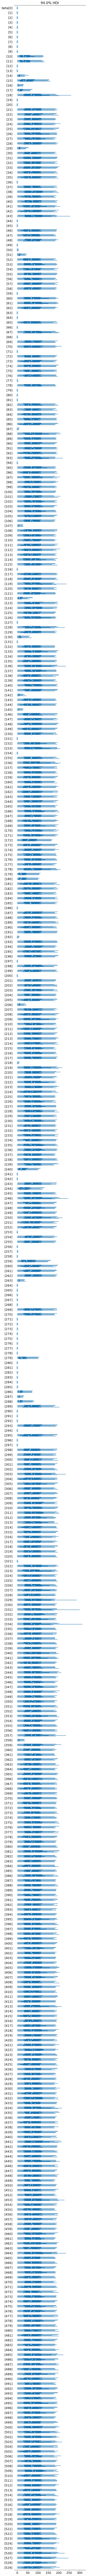

In [65]:
az.plot_forest(trace_mlr, var_names=["beta"])

/home/thejarmanitor/miniconda3/envs/outplayed/lib/python3.10/site-packages/arviz/plots/plot_utils.py:271: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (530) in plot_posterior, generating only 40 plots
  warnings.warn(


array([[<Axes: title={'center': 'beta\n0'}>,
        <Axes: title={'center': 'beta\n1'}>,
        <Axes: title={'center': 'beta\n2'}>,
        <Axes: title={'center': 'beta\n3'}>],
       [<Axes: title={'center': 'beta\n4'}>,
        <Axes: title={'center': 'beta\n5'}>,
        <Axes: title={'center': 'beta\n6'}>,
        <Axes: title={'center': 'beta\n7'}>],
       [<Axes: title={'center': 'beta\n8'}>,
        <Axes: title={'center': 'beta\n9'}>,
        <Axes: title={'center': 'beta\n10'}>,
        <Axes: title={'center': 'beta\n11'}>],
       [<Axes: title={'center': 'beta\n12'}>,
        <Axes: title={'center': 'beta\n13'}>,
        <Axes: title={'center': 'beta\n14'}>,
        <Axes: title={'center': 'beta\n15'}>],
       [<Axes: title={'center': 'beta\n16'}>,
        <Axes: title={'center': 'beta\n17'}>,
        <Axes: title={'center': 'beta\n18'}>,
        <Axes: title={'center': 'beta\n19'}>],
       [<Axes: title={'center': 'beta\n20'}>,
        <Axes: title={'center': 'beta\n

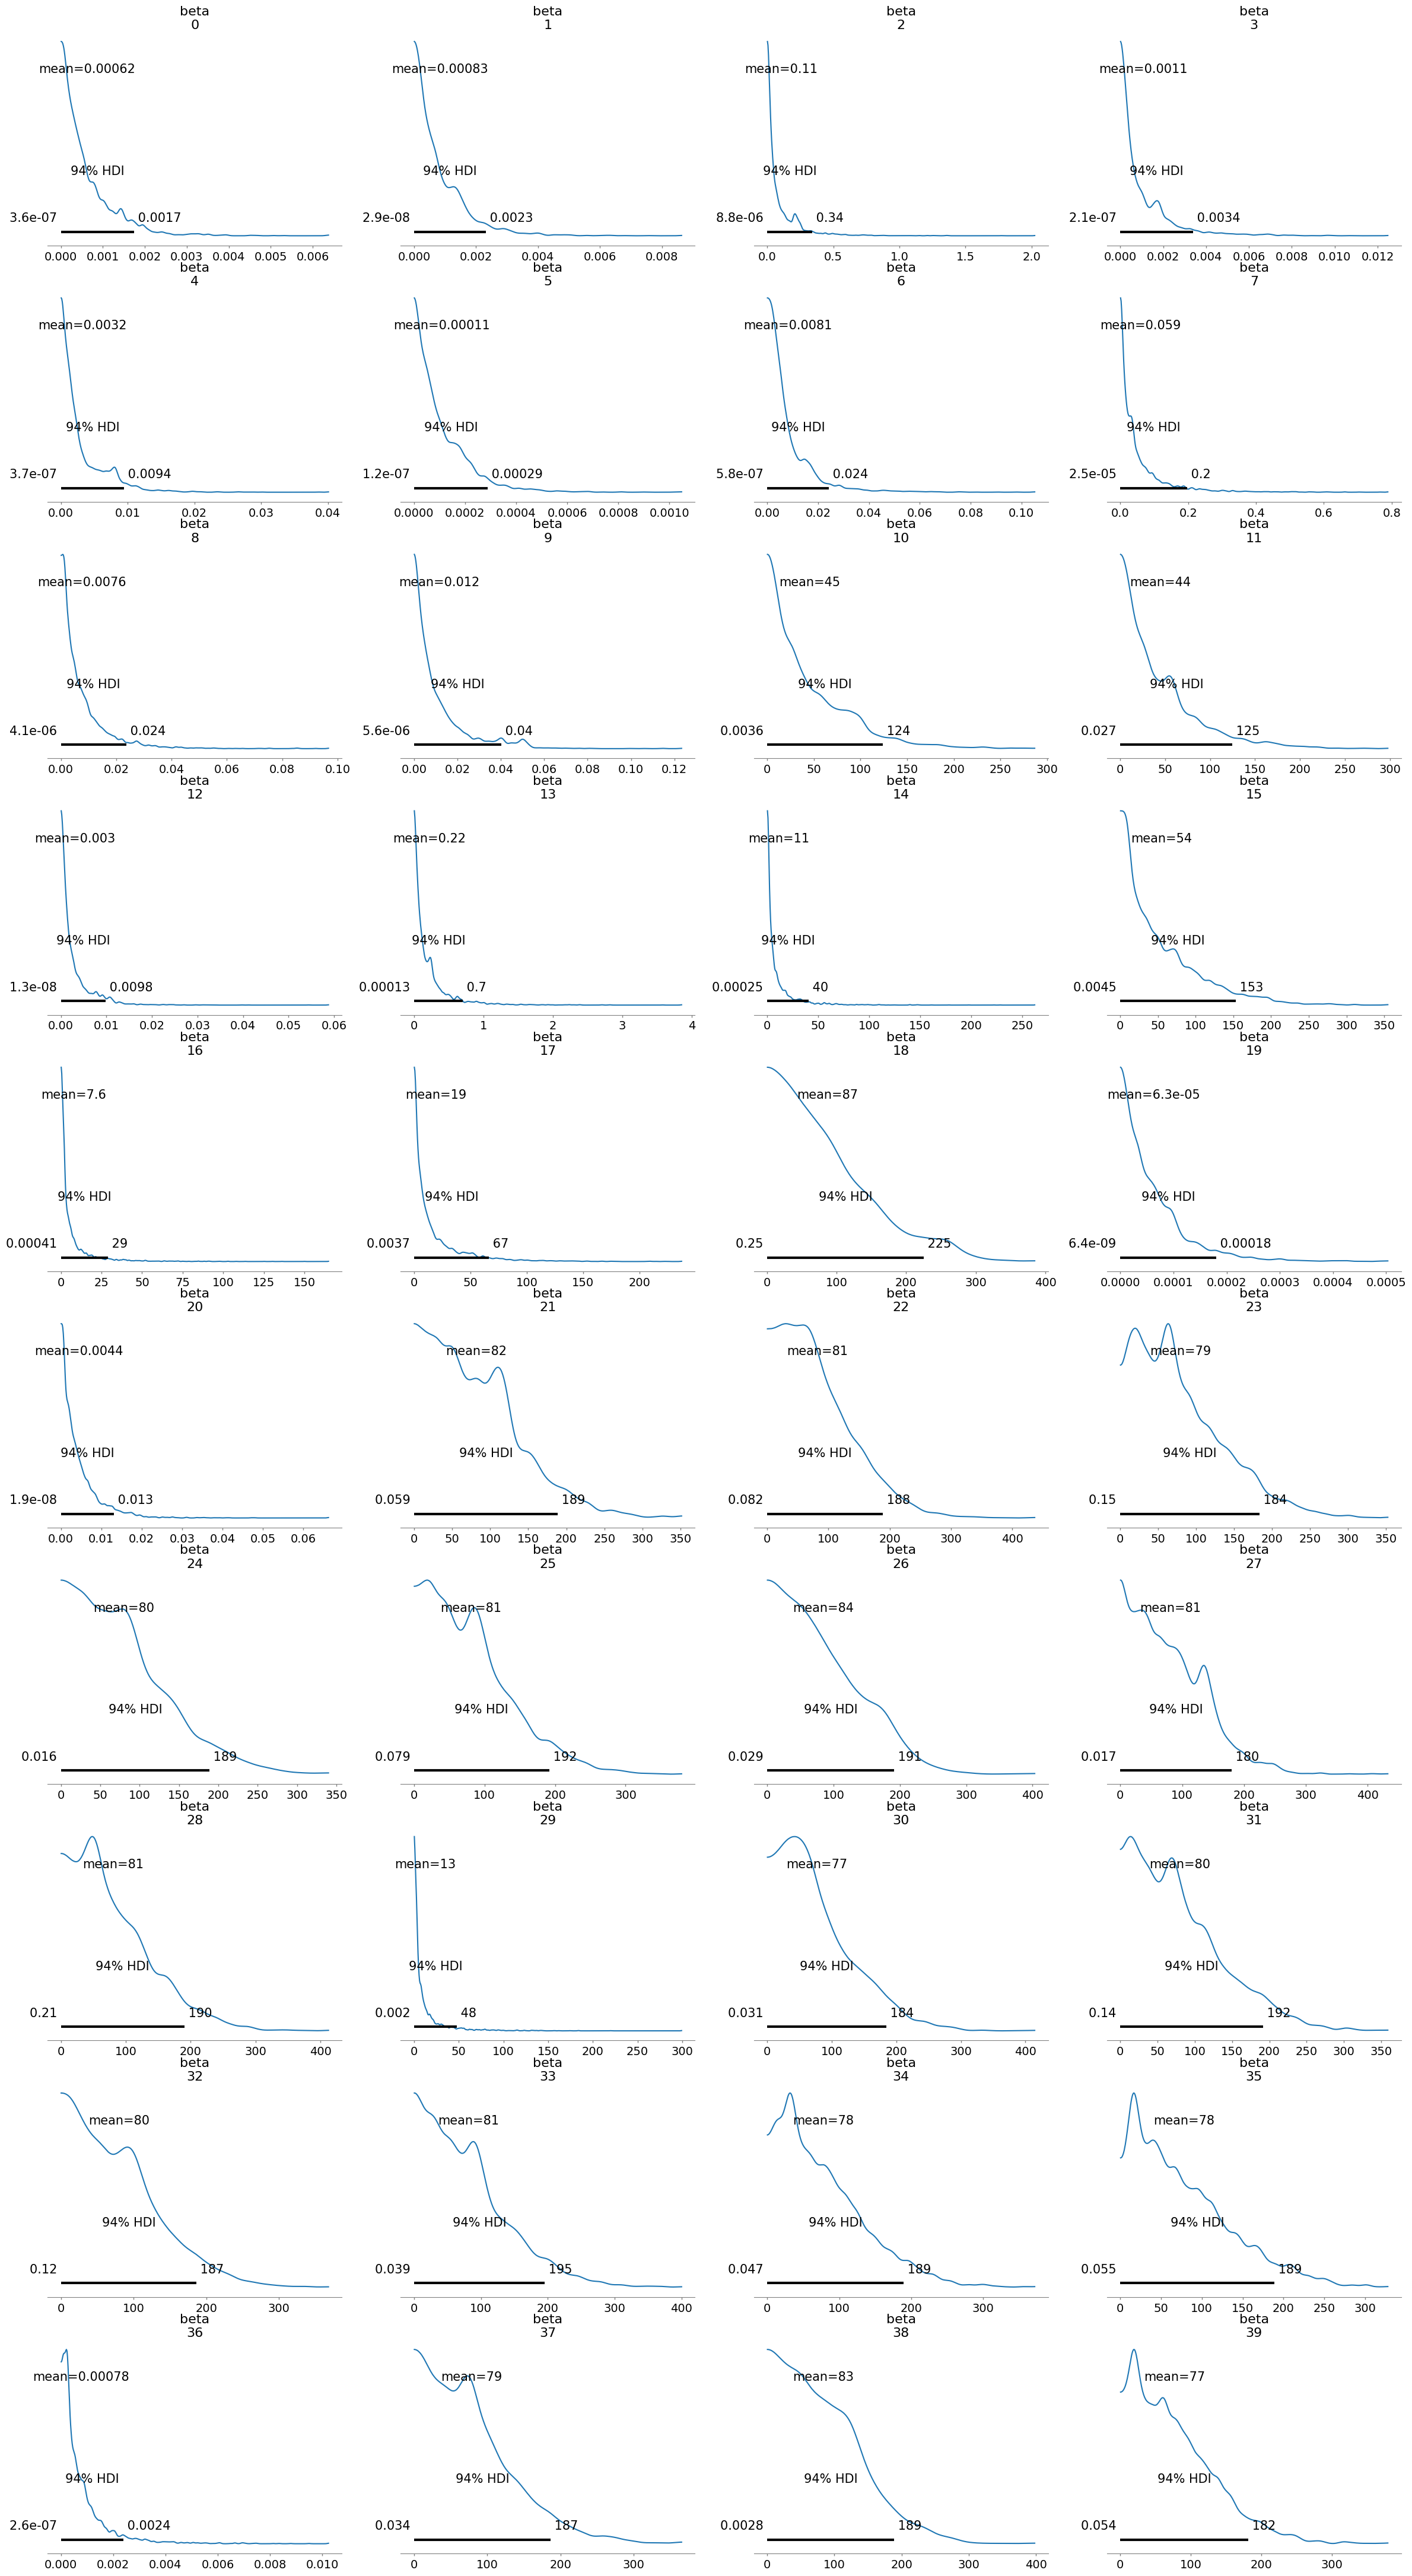

In [67]:
az.plot_posterior(trace_mlr, var_names=["beta"])